In [1]:
import sys
sys.path.append('/data_nfs/og86asub/netmap/netmap-evaluation/netmap')

import scanpy as sc
import time 

from src.utils.misc import write_config

from src.model.negbinautoencoder import *
import scanpy as sc

from sklearn.model_selection import train_test_split
import time
from captum.attr import GradientShap
from src.model.inferrence_simple import *
from src.utils.data_utils import attribution_to_anndata
import src.downstream.downstreammain as d
import numpy as np


from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import HDBSCAN

import os.path as op
import os

def create_model_zoo(data_tensor, n_models = 4, n_epochs = 5000, latent_dim=10):
    model_zoo = []
    for _ in range(n_models):

        data_train2, data_test2 = train_test_split(data_tensor,test_size=0.03, shuffle=True)

        trained_model2 = NegativeBinomialAutoencoder(input_dim=data_tensor.shape[1], latent_dim=latent_dim, dropout_rate = 0.0)
        trained_model2 = trained_model2.cuda()

        optimizer2 = torch.optim.Adam(trained_model2.parameters(), lr=1e-4)

        trained_model2 = train_autoencoder(
                trained_model2,
                data_train2.cuda(),
                optimizer2,
                num_epochs=n_epochs

            )
        model_zoo.append(trained_model2)
    return model_zoo


from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import HDBSCAN


def set_latent_true(model_zoo):
    for mo in model_zoo:
        mo.forward_mu_only = False
        mo.forward_theta_only = False
        mo.latent_only = True
    return model_zoo


def set_all_false(model_zoo):
    for mo in model_zoo:
        mo.forward_mu_only = False
        mo.forward_theta_only = False
        mo.latent_only = False
    return model_zoo


def pair_cooccurence(u, v):
  u_arr = np.array(u)
  v_arr = np.array(v)
  term1 = np.sum(u_arr-v_arr!=0)
  return term1 / len(u_arr)

def compute_consensus_clustering(model_zoo, data_tensor, adata):
    model_zoo = set_latent_true(model_zoo)
    clusterings = {}
    for m in range(len(model_zoo)):
        latent = model_zoo[m](data_tensor.cuda())
        latent = sc.AnnData(latent.detach().cpu().numpy())
        sc.pp.neighbors(latent)
        sc.tl.umap(latent)
        latent.obs = adata.obs
        sc.tl.leiden(latent, resolution=0.1)
        clusterings[f'leiden_{m}'] = latent.obs[f'leiden']
    model_zoo = set_all_false(model_zoo)

    clusterings = pd.DataFrame(clusterings)

    latent.obs = pd.concat([latent.obs, clusterings], axis=1)
    clustering = clusterings.values.astype(int) 

    pairwise_distances_flat = pdist(clustering, metric=pair_cooccurence)
    pairwise_distances_matrix = squareform(pairwise_distances_flat)

    hdb = HDBSCAN(min_cluster_size=50, metric= 'precomputed')
    hdb.fit(pairwise_distances_matrix)
    latent.obs['consensus'] = hdb.labels_


    return latent

def set_mu_true(model_zoo):
    # forward only mu
    for mo in model_zoo:
        mo.forward_mu_only = True
        mo.forward_theta_only = False
        mo.latent_only = False
    return model_zoo

def set_theta_true(model_zoo):
    # forward only mu
    for mo in model_zoo:
        mo.forward_mu_only = False
        mo.forward_theta_only = True
        mo.latent_only = False
    return model_zoo


import numpy as np
from scipy.stats import nbinom

def draw_neg_binomial(mu, theta, size=1):
    """
    Draws random samples from a negative binomial distribution given mu and theta.

    Args:
        mu (float): The mean of the negative binomial distribution.
        theta (float): The dispersion parameter (often denoted as 'alpha' in some contexts,
                    related to the number of successes).
        size (int or tuple of ints, optional): The number of samples to draw.
                                            Default is 1.

    Returns:
        ndarray or scalar: Drawn samples from the negative binomial distribution.
    """
    if mu <= 0 or theta <= 0:
        raise ValueError("mu and theta must be positive.")

    p = theta / (mu + theta)
    n = theta  # theta in this parameterization corresponds to 'n' in scipy

    # scipy.stats.nbinom uses 'n' (number of successes) and 'p' (probability of success)
    samples = nbinom.rvs(n, p, size=size)
    return samples

def sample_from_vectors(mus, thetas, size=1):
    """
    Draws random samples from negative binomial distributions defined by
    corresponding elements in the mu and theta vectors.

    Args:
        mus (np.ndarray): A vector of mean parameters.
        thetas (np.ndarray): A vector of dispersion parameters.
        size (int or tuple of ints, optional): The number of samples to draw
                                            for each mu-theta pair. Default is 1.

    Returns:
        np.ndarray: An array of samples. If size is 1, the output will have the
                    same shape as mus and thetas. If size is greater than 1,
                    the output will have an additional dimension for the samples.
    """
    mus = np.asarray(mus)
    thetas = np.asarray(thetas)

    if mus.shape != thetas.shape:
        raise ValueError("mus and thetas vectors must have the same shape.")

    num_distributions = mus.shape[0]
    all_samples = []

    for i in range(num_distributions):
        mu_i = mus[i]
        theta_i = thetas[i]
        samples_i = draw_neg_binomial(mu_i, theta_i, size=size)
        all_samples.append(samples_i)

    if size == 1:
        return np.array(all_samples).flatten()
    else:
        return np.array(all_samples)



def generate_background_data(model_zoo, data_tensor, latent):
    backgrounds = {}
    for i in latent.obs['consensus'].unique():
        if i!=-1:
            backgrounds[i] = []

    for m in range(len(model_zoo)):
        # Get average params over all 
        mean_theta = get_thetas(model_zoo[m], data_tensor)
        mean_mu = get_mus(model_zoo[m], data_tensor)
        samples_mean = sample_from_vectors(mean_mu, mean_theta, size=200).T


        mean_mus = get_mus_grouping(model_zoo[m], data_tensor, latent.obs['consensus'])
        mean_thetas = get_thetas_grouping(model_zoo[m], data_tensor, latent.obs['consensus'])

        for i in backgrounds.keys():
            backgrounds[i].append(sample_from_vectors(mean_mus[i], mean_thetas[i], size=200).T)

    for b in backgrounds.keys():
        backgrounds[b] = np.concatenate(backgrounds[b])
        backgrounds[b] = torch.tensor(backgrounds[b]).cuda()

    return backgrounds


def generate_background_data_avg(model_zoo, data_tensor):

    for m in range(len(model_zoo)):
        # Get average params over all 
        mean_theta = get_thetas(model_zoo[m], data_tensor)
        mean_mu = get_mus(model_zoo[m], data_tensor)
        samples_mean = sample_from_vectors(mean_mu, mean_theta, size=200).T
    
    return torch.tensor(samples_mean).cuda()


def compute_attributions(model_zoo, data_tensor, latent, gene_names, backgrounds, adata, n_top = 250):
    myexplainers = [GradientShap(mo) for mo in model_zoo]
    attributions = []
    for b in backgrounds.keys():
        aggregated_attribution, cou = inference_complete(myexplainers, data_tensor[latent.obs['consensus'] == b].cuda(), gene_names, backgrounds[b], xai_type='shap-like', num_iterations=5,n_top_genes=n_top )
        ad = attribution_to_anndata(aggregated_attribution, var=cou, obs=latent.obs[latent.obs['consensus'] == b])
        attributions.append(ad)
    return attributions
    
def concatenate_cluster_anndatas(attributions):
    aa = sc.concat(attributions, join = 'outer')
    # Concatenation somehow deletes the content of var
    aa.var['source']   = [l[0] for l in aa.var.index.str.split('_', expand=True)]
    aa.var['target']   = [l[1] for l in aa.var.index.str.split('_', expand=True)]
    return aa

import scipy.sparse as scs

def run_netmap(config, dataset_config):

    start_total = time.monotonic()
    
    ## Load config and setup outputs
    os.makedirs(config.output_directory, exist_ok=True)
    sc.settings.figdir = config.output_directory
    config.write_yaml(yaml_file=op.join(config.output_directory, 'config.yaml'))

    ## load data
    adata = sc.read_h5ad(config.input_data)
    

    ## Get the data matrix from the CustumAnndata obeject
    gene_names = np.array(adata.var.index)
    model_start = time.monotonic()
    if scs.issparse(adata.X):
        data_tensor = torch.tensor(adata.X.todense(), dtype=torch.float32)
    else:
        data_tensor = torch.tensor(adata.X, dtype=torch.float32)


    print(data_tensor.shape)

    model_zoo = create_model_zoo(data_tensor, n_models=config.n_models, n_epochs=1500)

    latent = compute_consensus_clustering(model_zoo, data_tensor, adata)
    backgrounds = generate_background_data(model_zoo, data_tensor, latent)
    attributions = compute_attributions(model_zoo, data_tensor, latent, gene_names, backgrounds, adata, config.n_top_edges)
    grn_adata = concatenate_cluster_anndatas(attributions)
    model_elapsed = time.monotonic()-model_start
    grn_adata.write_h5ad(op.join(config.output_directory,config.adata_filename))

    time_elapsed_total = time.monotonic()-start_total


    res = {'time_elapsed_total': time_elapsed_total, 'time_elapsed_netmap': model_elapsed} 
    write_config(res, file=op.join(config.output_directory, 'results.yaml'))
  


In [2]:
import yaml
def read_config(file):
    with open(file, "r") as f:
        config = yaml.safe_load(f)
    return config


In [3]:
from src.utils.netmap_config import NetmapConfig


#config = NetmapConfig.read_yaml("/data_nfs/og86asub/netmap/netmap-evaluation/results/configurations/netmap/config/perturb_seq/")
dataset_config = read_config("/data_nfs/og86asub/netmap/netmap-evaluation/results/configurations/data_simulation/config_easy/net_105_14145_net_135_14050_net_52_13287.config.yaml")



In [4]:
dataset_config

{'edgelist': ['net_105_14145/edges.tsv', 'net_135_14050/edges.tsv'],
 'nodelist': ['net_105_14145/nodes.tsv', 'net_135_14050/nodes.tsv'],
 'common_edges': ['net_52_13287/edges.tsv'],
 'common_nodes': ['net_52_13287/nodes.tsv'],
 'n_cells': 1000,
 'n_celltypes': 2,
 'seed': 11,
 'base_effect': 'standard-normal',
 'mean': 2.5,
 'sd': 1,
 'dataset_id': 'net_105_14145_net_135_14050_net_52_13287',
 'edgelist_1': None,
 'edgelist_2': None,
 'perturbed_genes': None}

In [5]:
op.basename(op.basename("/data_nfs/og86asub/netmap/netmap-evaluation/results/configurations/data_simulation/config_easy/net_105_43582_net_51_43266_net_82_42088.config.yaml"))

'net_105_43582_net_51_43266_net_82_42088.config.yaml'

In [6]:
import anndata as ad


In [7]:

## load data
adata = sc.read_h5ad('/data_nfs/og86asub/netmap/netmap-evaluation/data/simulated_data/config_easy/net_105_14145_net_135_14050_net_52_13287/data.h5ad')


## Get the data matrix from the CustumAnndata obeject
gene_names = np.array(adata.var.index)
model_start = time.monotonic()
data_tensor = torch.tensor(adata.X, dtype=torch.float32)

model_zoo = create_model_zoo(data_tensor, n_models=2, n_epochs=1000, latent_dim=10)



Epoch 1/1000, Loss: 45.4782
Epoch 11/1000, Loss: 5.1258
Epoch 21/1000, Loss: 4.2357
Epoch 31/1000, Loss: 3.9898
Epoch 41/1000, Loss: 3.8501
Epoch 51/1000, Loss: 3.7586
Epoch 61/1000, Loss: 3.6813
Epoch 71/1000, Loss: 3.6352
Epoch 81/1000, Loss: 3.5978
Epoch 91/1000, Loss: 3.5747
Epoch 101/1000, Loss: 3.5635
Epoch 111/1000, Loss: 3.5568
Epoch 121/1000, Loss: 3.5504
Epoch 131/1000, Loss: 3.5433
Epoch 141/1000, Loss: 3.5373
Epoch 151/1000, Loss: 3.5332
Epoch 161/1000, Loss: 3.5276
Epoch 171/1000, Loss: 3.5227
Epoch 181/1000, Loss: 3.5198
Epoch 191/1000, Loss: 3.5169
Epoch 201/1000, Loss: 3.5153
Epoch 211/1000, Loss: 3.5135
Epoch 221/1000, Loss: 3.5109
Epoch 231/1000, Loss: 3.5102
Epoch 241/1000, Loss: 3.5073
Epoch 251/1000, Loss: 3.5049
Epoch 261/1000, Loss: 3.5057
Epoch 271/1000, Loss: 3.5031
Epoch 281/1000, Loss: 3.5018
Epoch 291/1000, Loss: 3.5006
Epoch 301/1000, Loss: 3.4990
Epoch 311/1000, Loss: 3.4973
Epoch 321/1000, Loss: 3.4953
Epoch 331/1000, Loss: 3.4939
Epoch 341/1000, Loss: 3.

... storing 'cell_id' as categorical


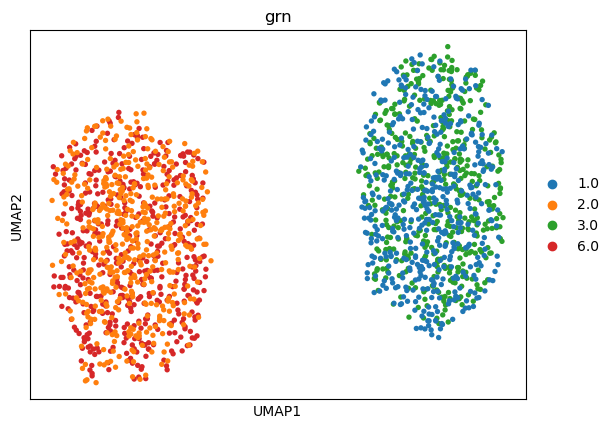

In [8]:
bg = model_zoo[1](data_tensor.cuda())[0].detach().cpu().numpy()
bg = ad.AnnData(bg)
bg.var = adata.var
bg.obs = adata.obs.copy()
bg.obs['grn'] = bg.obs['grn'] * 3
new = ad.concat([bg,adata])
sc.pp.scale(new)
sc.pp.pca(new, n_comps=10)
sc.pp.neighbors(new)
sc.tl.umap(new)
new.obs['grn'] = pd.Categorical(new.obs['grn'] )
sc.pl.umap(new , color = 'grn')

In [9]:
import cuml
import pandas as pd
import numpy as np
from tqdm import tqdm
import rapids_singlecell as rsc
from numpy import hstack

import numpy as np
from scipy.stats import nbinom

def inference_complete(lrp, data, gene_names, background, xai_type= 'lrp-like', num_iterations=10, n_top_genes=500) -> pd.DataFrame:
    """
    Compute the LRP values for all targets (All genes in anndata object)
    Filter attribution values

    Args:
    configuration_dict: configuration of trained models
    data: Passed as CustomAnndataLoader instance
    tf_gene_names: List of genes to be considered as transcription factors.

    returns: List of target wise attributions per edge
    """
    
    name_list = []
    ## Presumably all genes in adata var have been used as target genes 
    ### This is currentlyWednesday unlikely due to random sampling
    top_values = None
    attribution_list =  []
    target_names = []
    for g in tqdm(range(data.shape[1])):
        attribution_all, names = inference_one_target(g, lrp, data, gene_names, background, 
                                                        xai_type=xai_type, n_top_genes = n_top_genes, num_iterations=num_iterations)
        
        attribution_list.append(attribution_all)
        name_list = name_list + names
        target_names = target_names+[gene_names[g]]* (attribution_all.shape[1])
    attribution_list = hstack( attribution_list)

    index_list = [f"{s}_{t}" for (s, t) in zip(name_list, target_names)]
    cou = pd.DataFrame({'index': index_list, 'source':name_list, 'target':target_names})
    cou = cou.set_index('index')
    return attribution_list, cou

def inference_one_target(
    target_gene,
    lrp_model,
    input_data,
    gene_names,
    background,
    xai_type='lrp-like',
    n_top_genes = 500,
    num_iterations = 10
   
):
    """
    Run inference for one target gene, masking its contributions multiple times.

    Args:
        target_gene: Gene to run inference for.
        lrp_model: The trained model for Layer-wise Relevance Propagation (LRP).
        data: Data, instance of CustomAnndataLoader.
        tf_gene_names: List of transcription factor gene names.
        lrp_process: Process to apply to LRP values ('abs' for absolute values).
        nt: Neural Taylor method ('lrp', 'smoothgrad', 'vargrad').
        masking_percentage: Percentage of input values to mask.
        num_iterations: Number of noisy perturbations to perform.

    Returns:
        A tuple containing:
            - Aggregated attribution values after multiple inferences with masking.
            - Names of transcription factors.
    """


    attributions_list = []
    for model in lrp_model:
        for _ in range(num_iterations):
            if xai_type == 'lrp-like':
                attribution = model.attribute(input_data, target=target_gene)
                    
            elif xai_type == 'shap-like':
                attribution = model.attribute(input_data, background, target = target_gene, n_samples = 1)
                #attribution_2 = model.attribute(input_data, background_2, target = target_gene, n_samples=1)
                diff = np.abs((attribution).detach().cpu().numpy())
                
            else:
                raise ValueError('No such method')

            attributions_list.append(diff)

    # Stack the attribution runs
    diff = np.stack(attributions_list)
    # Compute aggregate over stack
    diff = np.mean(attributions_list, axis=0)
    m2 = pd.DataFrame(diff).mean()
    idx = (m2).nlargest(n_top_genes).index
    diff = diff[:, idx]
    names = list(gene_names[idx])
    return diff, names




def draw_neg_binomial(mu, theta, size=1):
  """
  Draws random samples from a negative binomial distribution given mu and theta.

  Args:
    mu (float): The mean of the negative binomial distribution.
    theta (float): The dispersion parameter (often denoted as 'alpha' in some contexts,
                   related to the number of successes).
    size (int or tuple of ints, optional): The number of samples to draw.
                                           Default is 1.

  Returns:
    ndarray or scalar: Drawn samples from the negative binomial distribution.
  """
  if mu <= 0 or theta <= 0:
    raise ValueError("mu and theta must be positive.")

  p = theta / (mu + theta)
  n = theta  # theta in this parameterization corresponds to 'n' in scipy

  # scipy.stats.nbinom uses 'n' (number of successes) and 'p' (probability of success)
  samples = nbinom.rvs(n, p, size=size)
  return samples

def sample_from_vectors(mus, thetas, size=1):
  """
  Draws random samples from negative binomial distributions defined by
  corresponding elements in the mu and theta vectors.

  Args:
    mus (np.ndarray): A vector of mean parameters.
    thetas (np.ndarray): A vector of dispersion parameters.
    size (int or tuple of ints, optional): The number of samples to draw
                                           for each mu-theta pair. Default is 1.

  Returns:
    np.ndarray: An array of samples. If size is 1, the output will have the
                same shape as mus and thetas. If size is greater than 1,
                the output will have an additional dimension for the samples.
  """
  mus = np.asarray(mus)
  thetas = np.asarray(thetas)

  if mus.shape != thetas.shape:
    raise ValueError("mus and thetas vectors must have the same shape.")

  num_distributions = mus.shape[0]
  all_samples = []

  for i in range(num_distributions):
    mu_i = mus[i]
    theta_i = thetas[i]
    samples_i = draw_neg_binomial(mu_i, theta_i, size=size)
    all_samples.append(samples_i)

  if size == 1:
    return np.array(all_samples).flatten()
  else:
    return np.array(all_samples)



In [1]:



nets = [pd.read_csv(op.join("/data_nfs/og86asub/netmap/netmap-evaluation/data/clustered_network/", filename), sep='\t') for filename in dataset_config['edgelist']]


NameError: name 'dataset_config' is not defined

In [11]:
nets

[    source    target
 0    GATA3     ZC3H8
 1    GATA3    ZNF217
 2    GATA3    ARID5B
 3    GATA3    ZNF503
 4    GATA3    ATP2B1
 ..     ...       ...
 105  CREB5  ATP6V0E1
 106  CREB5      DGKG
 107  CREB5  MAPKAPK3
 108  CREB5   RASGRP3
 109  CREB5       RDX
 
 [110 rows x 2 columns],
      source target
 0     PLAG1  XRCC1
 1     PLAG1  CRLF1
 2     PLAG1  ABCC6
 3    ZNF148   ODC1
 4    ZNF148    GHR
 ..      ...    ...
 162   STOX1  CCNB1
 163   STOX1   CCNC
 164   RBCK1  CCNB1
 165   RBBP8    ATM
 166    RYBP   CDC6
 
 [167 rows x 2 columns]]

In [12]:
import rapids_singlecell as rsc
import anndata as ad
from captum.attr import GradientShap

In [13]:
from numpy import vstack
def inference_complete(lrp, data, gene_names, background, xai_type= 'lrp-like', num_iterations=10, n_top_genes=500) -> pd.DataFrame:
    """
    Compute the LRP values for all targets (All genes in anndata object)
    Filter attribution values

    Args:
    configuration_dict: configuration of trained models
    data: Passed as CustomAnndataLoader instance
    tf_gene_names: List of genes to be considered as transcription factors.

    returns: List of target wise attributions per edge
    """
    
    name_list = []
    ## Presumably all genes in adata var have been used as target genes 
    ### This is currentlyWednesday unlikely due to random sampling
    top_values = None
    attribution_list =  []
    target_names = []
    clustering_list = []
    for g in tqdm(range(data.shape[1])):
        attribution_all, names = inference_one_target(g, lrp, data, gene_names, background, 
                                                        xai_type=xai_type, n_top_genes = n_top_genes, num_iterations=num_iterations)
        
        attribution_list.append(attribution_all.X)
        clustering_list.append(attribution_all.obs[f'clu_{g}'])
        name_list = name_list + names
        target_names = target_names+[gene_names[g]]* (attribution_all.shape[1])
    attribution_list = hstack( attribution_list)
    clustering_list = hstack(clustering_list)
    index_list = [f"{s}_{t}" for (s, t) in zip(name_list, target_names)]
    cou = pd.DataFrame({'index': index_list, 'source':name_list, 'target':target_names})
    cou = cou.set_index('index')
    return attribution_list, cou, clustering_list


In [14]:
from sklearn.cluster import SpectralClustering
from statsmodels.stats.nonparametric import rank_compare_2indep

def inference_one_target(
    target_gene,
    lrp_model,
    input_data,
    gene_names,
    background,
    xai_type='lrp-like',
    n_top_genes = 500,
    num_iterations = 10
   
):
    """
    Run inference for one target gene, masking its contributions multiple times.

    Args:
        target_gene: Gene to run inference for.
        lrp_model: The trained model for Layer-wise Relevance Propagation (LRP).
        data: Data, instance of CustomAnndataLoader.
        tf_gene_names: List of transcription factor gene names.
        lrp_process: Process to apply to LRP values ('abs' for absolute values).
        nt: Neural Taylor method ('lrp', 'smoothgrad', 'vargrad').
        masking_percentage: Percentage of input values to mask.
        num_iterations: Number of noisy perturbations to perform.

    Returns:
        A tuple containing:
            - Aggregated attribution values after multiple inferences with masking.
            - Names of transcription factors.
    """


    attributions_list = []
    sign = []
    for model in lrp_model:
        #for _ in range(num_iterations):
        if xai_type == 'lrp-like':
            attribution = model.attribute(input_data)
                
        elif xai_type == 'shap-like':

            attribution = model.attribute(input_data, baselines = background, target = target_gene)
            
            my_att = ad.AnnData(attribution.detach().cpu().numpy())
            rsc.get.anndata_to_GPU(my_att) # moves `.X` to the GPU
            rsc.pp.scale(my_att)
            rsc.pp.pca(my_att,n_comps=20 )
            rsc.pp.neighbors(my_att, n_neighbors=10)
            
            rsc.get.anndata_to_CPU(my_att)
            sclu = SpectralClustering( n_clusters=2)
            sclu = sclu.fit(my_att.obsp['connectivities'])
            my_att.obs[f'clu_{target_gene}'] = pd.Categorical(sclu.labels_)
            print(pd.DataFrame(sclu.labels_).value_counts())

            a = my_att.X
            statisi =rank_compare_2indep(x1=a[sclu.labels_==1], x2 = a[sclu.labels_==0])
            sign.append(np.where(statisi.pvalue<(0.01/(data_tensor.shape[1]*data_tensor.shape[1]))))

            attributions_list.append(a)

        else:
            raise ValueError('No such method')

    counts = pd.DataFrame(pd.DataFrame(np.concat(sign, axis = 1).T).value_counts().reset_index())
    counts.columns = ['index_g', 'counter']
    all_sig  = np.array(counts[counts.counter>=1].index_g)
    
    diff = np.stack(attributions_list)
    # Compute aggregate over stack
    diff = np.mean(attributions_list, axis=0)
    diff = diff[:, all_sig]
    return diff, sclu.labels_, gene_names[all_sig], my_att


In [15]:
nets0 = nets[0]
nets1 = nets[1]


In [16]:
nets0

,source,target
0,GATA3,ZC3H8
1,GATA3,ZNF217
2,GATA3,ARID5B
3,GATA3,ZNF503
4,GATA3,ATP2B1
...,...,...
105,CREB5,ATP6V0E1
106,CREB5,DGKG
107,CREB5,MAPKAPK3
108,CREB5,RASGRP3


In [17]:
model_zoo = set_mu_true(model_zoo)


In [18]:
from captum.attr import LRP, IntegratedGradients

In [19]:
myexplainers = [IntegratedGradients(mo) for mo in model_zoo]
data_tensor = data_tensor.cuda()
idx = torch.randperm(data_tensor.nelement())
tens1 = data_tensor.view(-1)[idx].view(data_tensor.size())


#


In [20]:
np.where(gene_names == 'ATP2B1')

(array([22]),)

In [21]:
i = 0
myatt, clu, names, dd = inference_one_target( 22,
    myexplainers,
    data_tensor,
    gene_names,
    data_tensor,
    xai_type='shap-like',
    n_top_genes = 300,
    num_iterations = 10)


#print(f'Gene releavnt: {gene_names[i] in relevant}')
print(f"Net0: {nets0[nets0.target.isin(names)].shape[0]}")
print(f"Net1: {nets1[nets1.target.isin(names)].shape[0]}")

print(pd.DataFrame(clu).value_counts())

0
0    990
1     10
Name: count, dtype: int64
0
0    990
1     10
Name: count, dtype: int64
Net0: 0
Net1: 0
0
0    990
1     10
Name: count, dtype: int64


KeyError: 'Could not find key clu_90 in .var_names or .obs.columns.'

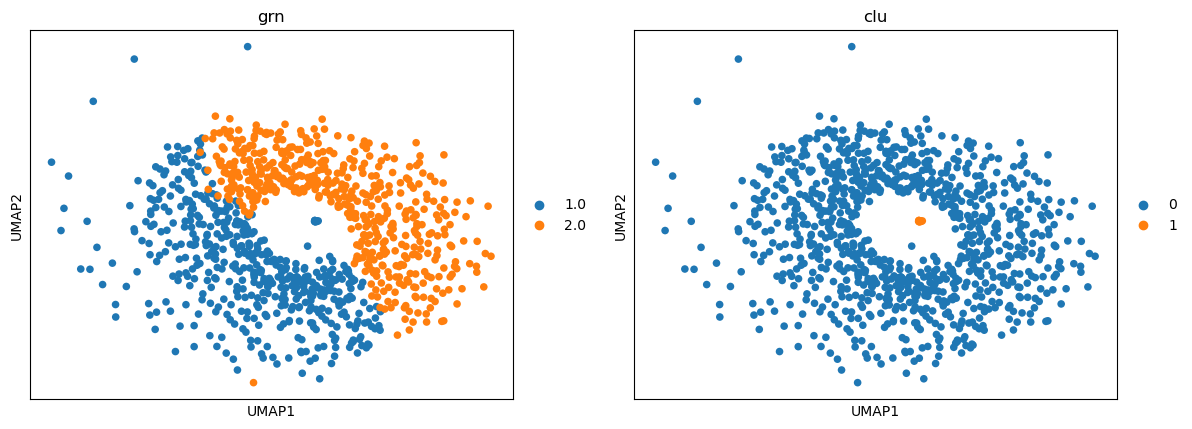

In [22]:
sclu = SpectralClustering( n_clusters=2)
sclu = sclu.fit(dd.obsp['connectivities'])
sc.tl.umap(dd)
dd.obs['clu'] = pd.Categorical(clu)
dd.obs['grn'] = pd.Categorical(adata.obs['grn'])
sc.pl.umap(dd, color=[ 'grn', 'clu', 'clu_90'])

In [ ]:
dd

AnnData object with n_obs × n_vars = 1000 × 292
    obs: 'clu_23', 'clu', 'grn'
    var: 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'grn_colors', 'clu_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
attribution_list, cou, clustering_list = inference_complete(myexplainers, data_tensor, gene_names, torch.tensor(bg).cuda(), xai_type= 'shap-like', num_iterations=10, n_top_genes=50)

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)

In [ ]:
clustering_list = np.array(clustering_list).T

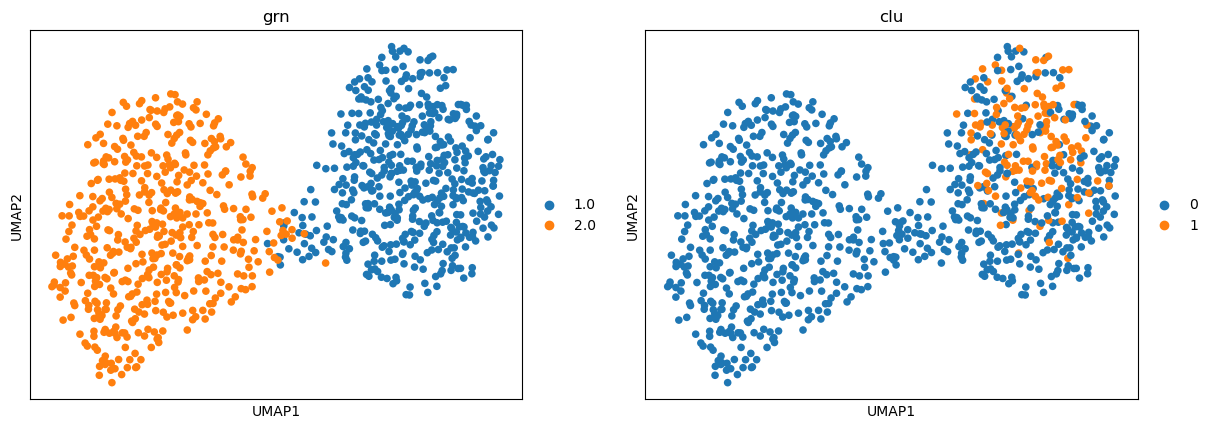

     index_g  counter
0        289        2
1        288        2
2          1        2
3          2        2
4        242        2
..       ...      ...
259      250        1
260        3        1
261        0        1
262      290        1
263      291        1

[264 rows x 2 columns]


In [ ]:
myatt.shape

(1000, 0)

In [ ]:
len(set(gene_names[np.where(pd.DataFrame(np.concat(sign, axis = 1).T).value_counts()<280)[0]] ).intersection(not_relevant))

52

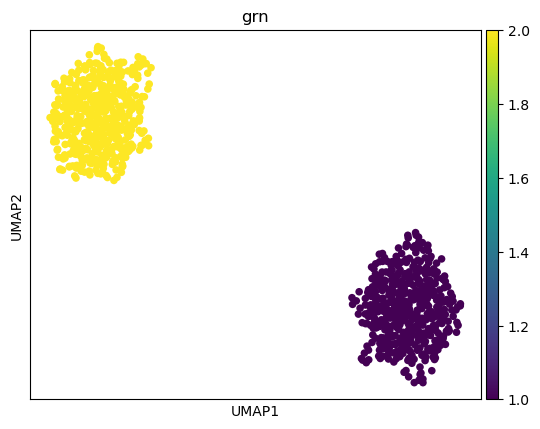

In [ ]:
sc.pp.scale(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color = 'grn')

... storing 'cell_id' as categorical


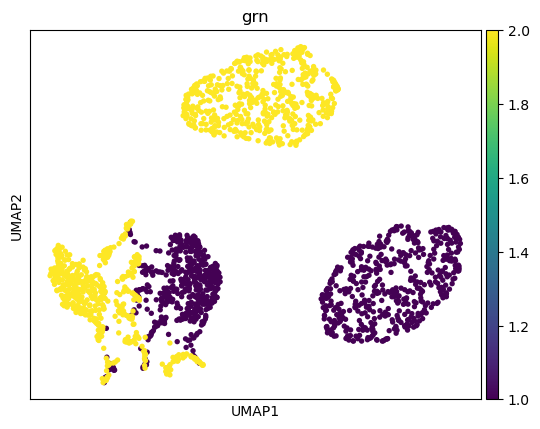

In [ ]:
new.obs

""
0
1
2
3
4
...
cell496.1
cell497.1
cell498.1
cell499.1


In [ ]:
counts[counts.counter>10].index_g

0      237
1      220
2      256
3      191
4      129
      ... 
287    165
288     50
289    110
290    157
291    286
Name: index_g, Length: 292, dtype: int64

array([[<Axes: title={'center': 'counter'}>]], dtype=object)

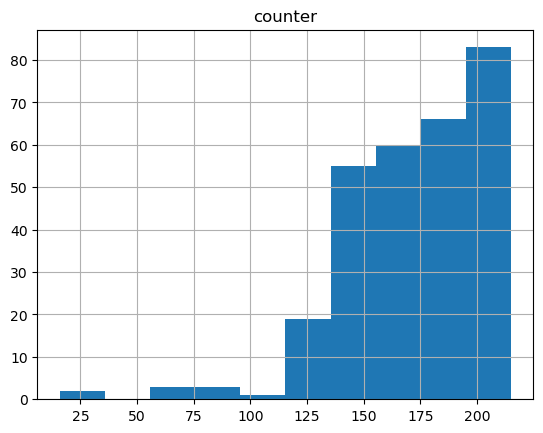

In [ ]:
counts.hist('counter')

In [ ]:
set(gene_names[counts[counts.counter<100].index_g]).intersection(not_relevant)

{'CILP', 'COL3A1', 'NOG', 'TGFB3', 'ZNF174'}

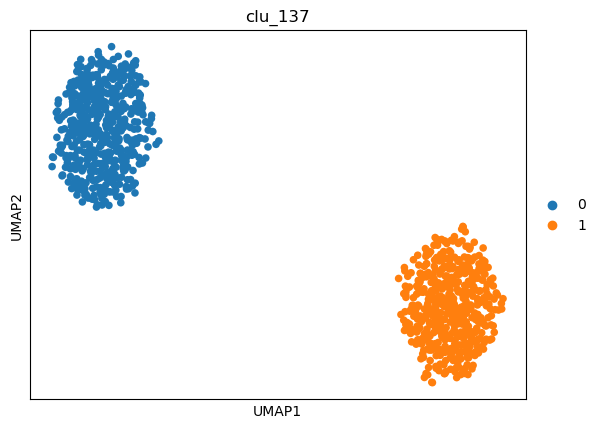

In [ ]:
sc.tl.umap(myatt)
sc.pl.umap(myatt, color='clu_137')

In [ ]:
not_relevant = set(gene_names).difference(set(np.unique(np.concat([nets0.source, nets0.target, nets1.source, nets1.target]))))

In [ ]:
relevant = set(gene_names).intersection(set(np.unique(np.concat([ nets0.target,  nets1.target]))))

In [ ]:
relevant

{'AAR2',
 'ABCC1',
 'ABCC6',
 'ACOT4',
 'ACTR6',
 'AKAP10',
 'ANAPC4',
 'ANO2',
 'APBA1',
 'APBB3',
 'APEX1',
 'AQP1',
 'ARID5B',
 'ATM',
 'ATOX1',
 'ATP2B1',
 'ATP6V0E1',
 'ATXN2',
 'AURKAIP1',
 'BARD1',
 'BBX',
 'BCAS3',
 'BLCAP',
 'BLOC1S1',
 'BPIFB1',
 'BRCA2',
 'BRPF1',
 'BTC',
 'CALN1',
 'CAMK2N1',
 'CCL27',
 'CCNB1',
 'CCNC',
 'CD5',
 'CDC6',
 'CDKN3',
 'CHI3L1',
 'CHST2',
 'CHST4',
 'CLIC3',
 'COP1',
 'COQ8A',
 'CRLF1',
 'CTNNA2',
 'DDB1',
 'DDR2',
 'DFFA',
 'DGKG',
 'DNAJC17',
 'DUSP16',
 'DUSP8',
 'ECE1',
 'EFNB3',
 'EPB41',
 'ERCC2',
 'FAM169BP',
 'FBXO11',
 'FGFRL1',
 'FNDC3B',
 'FUT7',
 'FZD7',
 'GABRA6',
 'GADD45A',
 'GALNT10',
 'GCNT4',
 'GFRA1',
 'GHR',
 'GLMN',
 'GPR162',
 'GRM7',
 'HAP1',
 'HCFC1',
 'HDAC2',
 'HIRA',
 'HMMR',
 'HNRNPA2B1',
 'HNRNPU',
 'ICAM5',
 'ID4',
 'IFT20',
 'IGF1R',
 'IL12RB2',
 'IL1RL1',
 'ITGB3BP',
 'ITPK1',
 'ITPR2',
 'KDM1B',
 'KHSRP',
 'KLK1',
 'KLRC1',
 'LCN8',
 'LIG1',
 'LIG3',
 'LMO4',
 'LRMDA',
 'LRRC61',
 'LRRN3',
 'MAPKAPK3',
 'MBNL2',

In [ ]:
def get_mus_grouping(model, data_tensor, grouping):
    model.forward_mu_only = True
    model.forward_theta_only = False
    model.latent_only = False

    lat_mu = model(data_tensor.cuda())


  
    return lat_mu.detach().cpu().numpy()

def get_thetas_grouping(model, data_tensor, grouping):
    model.forward_mu_only = False
    model.forward_theta_only = True
    model.latent_only = False

    lat_mu = model(data_tensor.cuda())


    return lat_mu.detach().cpu().numpy()


array([[  8,  98,  85, ...,   0,  51, 142],
       [  6,  48, 110, ...,   0,  52,  35],
       [  7, 127, 148, ...,   0,  62,  41],
       ...,
       [  6,  95, 199, ...,   3,  71,  24],
       [  5,  67, 138, ...,   0,  78,  70],
       [ 16, 140,  82, ...,   0,  55,  82]], shape=(200, 292))

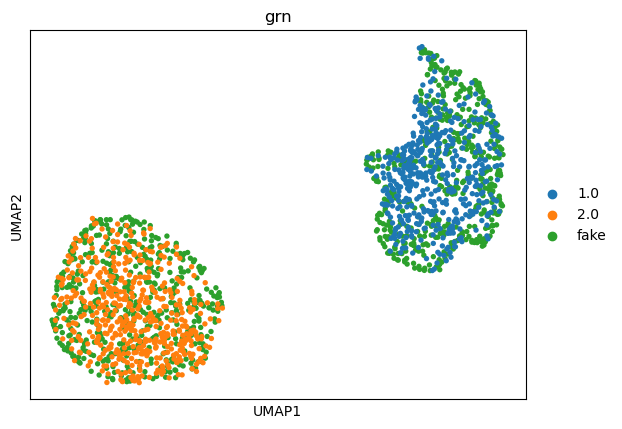

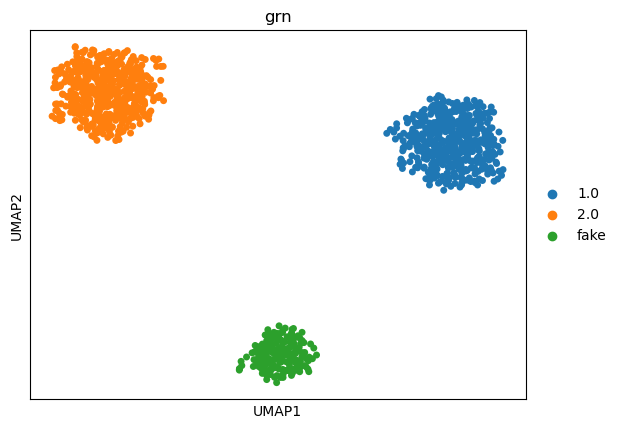

In [ ]:
not_relevant

{'ACTG2',
 'ADAM12',
 'AGTR1',
 'ALPI',
 'ANKRD1',
 'ARID1A',
 'ASIC3',
 'BAMBI',
 'CCN1',
 'CCNG2',
 'CILP',
 'COL3A1',
 'COL7A1',
 'CSRP2',
 'DAP',
 'DMP1',
 'DSG4',
 'FBLN5',
 'FSHB',
 'FSTL3',
 'GADD45B',
 'GAST',
 'HAS1',
 'ITGA11',
 'LAMB3',
 'LAMC2',
 'MSTN',
 'NODAL',
 'NOG',
 'OCLN',
 'PDGFB',
 'PRRX1',
 'PRRX2',
 'PSMD9',
 'PTPRK',
 'RGCC',
 'SERPINE1',
 'SKIL',
 'SMAD2',
 'SMAD3',
 'SMAD4',
 'SSTR2',
 'TGFB3',
 'TGIF1',
 'THBS2',
 'TIMP3',
 'TNC',
 'TPSAB1',
 'TPSD1',
 'XIAP',
 'ZNF14',
 'ZNF174'}

In [ ]:
np.where(gene_names == 'MXI1')

(array([156]),)

In [ ]:
nets1[nets1.source == 'MAX']

,source,target
8,MAX,YBX1
9,MAX,MXI1
10,MAX,MNT
11,MAX,SIN3A
12,MAX,ODC1
13,MAX,CCNB1
14,MAX,GADD45A
15,MAX,PTMA
16,MAX,MYCT1
17,MAX,OPRK1


In [ ]:
myatt, names = inference_one_target( 137,
    myexplainers,
    data_tensor,
    gene_names,
    backgrounds,
    xai_type='shap-like',
    n_top_genes = 50,
    num_iterations = 10)



In [ ]:
set(names).intersection(set(list(nets0.target)))

{'ACTR6',
 'APBA1',
 'ATOX1',
 'BBX',
 'BCAS3',
 'BLCAP',
 'CCL27',
 'CHST4',
 'COP1',
 'FAM169BP',
 'FUT7',
 'GALNT10',
 'GCNT4',
 'GPR162',
 'IL12RB2',
 'KDM1B',
 'KLK1',
 'LCN8',
 'MAPKAPK3',
 'MYH3',
 'NETO1',
 'PPIL2',
 'RAPGEF3',
 'RTN4IP1',
 'SENP1',
 'SEPTIN7',
 'SMARCA2',
 'SPEF2',
 'SVIL',
 'TLR5',
 'TRDV1',
 'VAPB',
 'ZNF507'}

In [ ]:
set(names).intersection(set(list(nets1.target)))

{'ABCC6',
 'COQ8A',
 'CRLF1',
 'GADD45A',
 'MDC1',
 'MRPS17',
 'MYCT1',
 'RNLS',
 'SDR42E1',
 'TOP2A'}

In [ ]:
nets1[nets1.source == 'GATA3']

,source,target


In [ ]:
nets0[nets0.source == 'GATA3']

,source,target
0,GATA3,ZC3H8
1,GATA3,ZNF217
2,GATA3,ARID5B
3,GATA3,ZNF503
4,GATA3,ATP2B1
...,...,...
70,GATA3,IL12RB2
71,GATA3,ACTR6
72,GATA3,AURKAIP1
73,GATA3,POLR1F


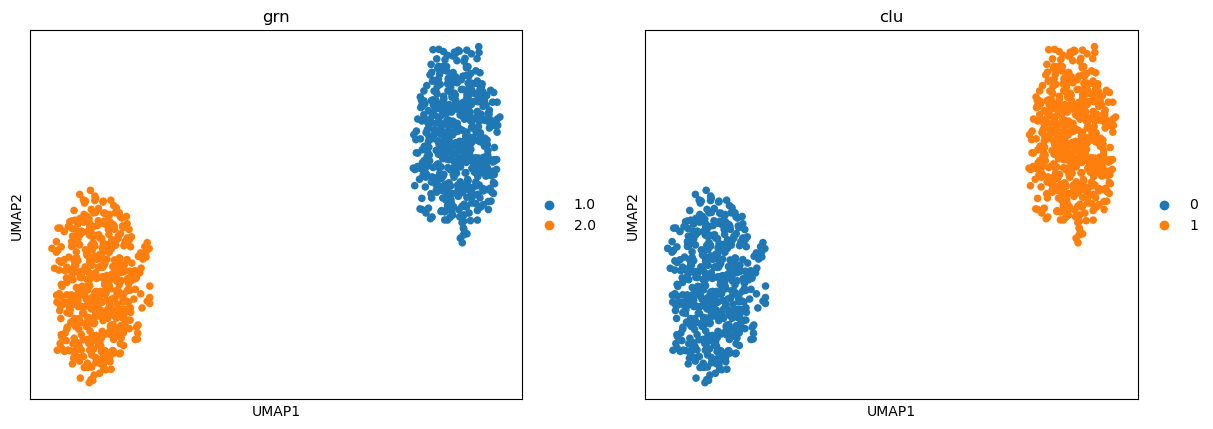

In [ ]:
sclu = SpectralClustering( n_clusters=2)
sclu = sclu.fit(myatt.obsp['connectivities'])
sc.tl.umap(myatt)
myatt.obs['clu'] = pd.Categorical(sclu.labels_)
myatt.obs['grn'] = pd.Categorical(adata.obs['grn'])
sc.pl.umap(myatt, color=[ 'grn', 'clu'])

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


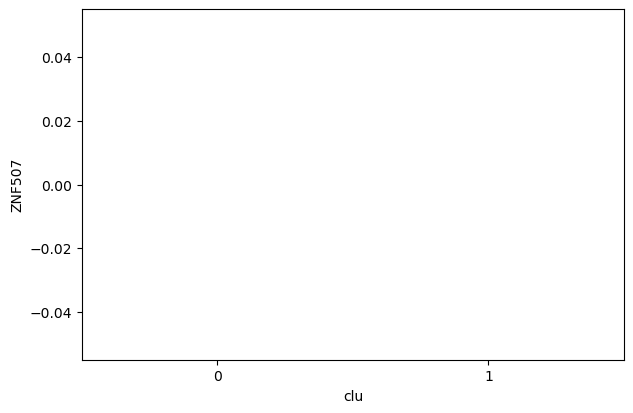

In [ ]:

sc.pl.violin(adata, keys = ['ZNF507'], groupby='clu')

In [ ]:
sc.pl.violin(adata, keys=['209'], groupby='grn')

KeyError: "Could not find keys '['209']' in columns of `adata.obs` or in adata.var_names."

In [ ]:
sc.pl.violin(adata, keys=list(set(names).intersection(relevant)), groupby='guide_identity')

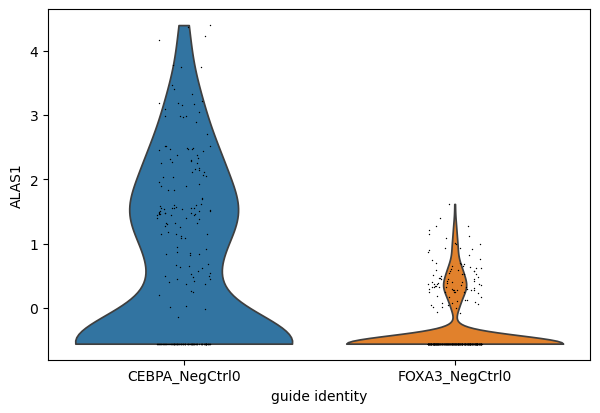

In [ ]:
sc.pl.violin(adata, keys = ['ALAS1'], groupby='guide_identity')

In [ ]:
myatt.X.get()

array([[-0.8624636 , -0.19173929,  0.13513803, ...,  0.05662109,
        -0.05966145, -0.05605432],
       [ 0.26498002,  3.9754796 ,  0.13513803, ...,  0.05662109,
         1.6161659 , -0.05605432],
       [ 0.26498002, -0.08491465,  0.13513803, ...,  0.05662109,
        -0.05966145, -1.6077759 ],
       ...,
       [-0.17413425,  0.01115396,  0.13513803, ...,  0.05662109,
        -0.05966145,  1.3445433 ],
       [ 0.26498002,  0.01115396,  0.13513803, ...,  0.05662109,
        -0.05966145, -0.6649277 ],
       [ 5.0237675 , -2.018781  ,  0.13513803, ...,  0.05662109,
        -0.05966145, -2.6501358 ]], shape=(738, 2000), dtype=float32)

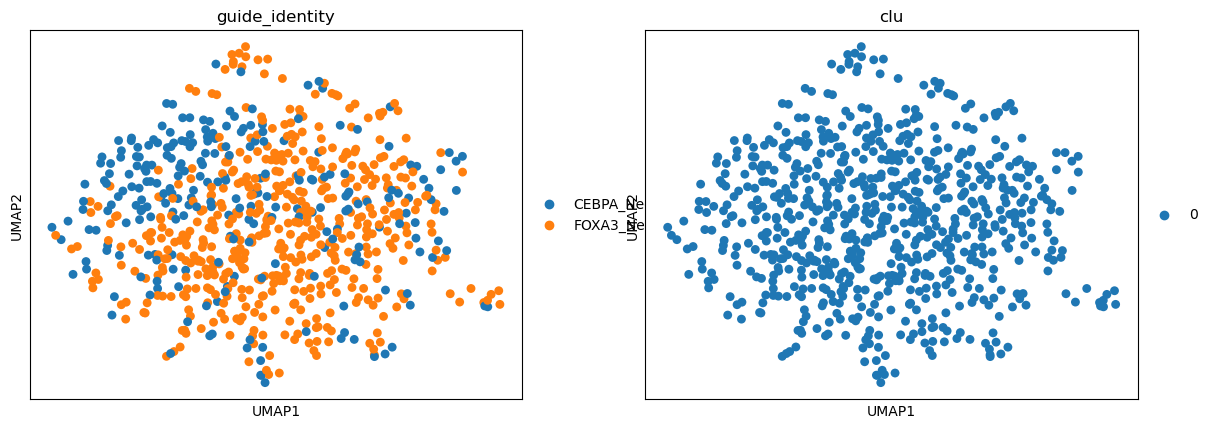

In [ ]:
attributions = compute_attributions(model_zoo, data_tensor, latent, gene_names, backgrounds, adata, n_top=150)


  0%|          | 1/232 [00:00<03:30,  1.10it/s]

1


  1%|          | 2/232 [00:01<03:46,  1.02it/s]

2


  1%|▏         | 3/232 [00:02<03:28,  1.10it/s]

2
3
3


  3%|▎         | 6/232 [00:05<03:13,  1.17it/s]

6


  3%|▎         | 7/232 [00:06<03:11,  1.18it/s]

6
7
7
7
7


  4%|▍         | 10/232 [00:08<03:06,  1.19it/s]

10


  6%|▌         | 13/232 [00:11<03:02,  1.20it/s]

13


  6%|▋         | 15/232 [00:13<03:08,  1.15it/s]


KeyboardInterrupt: 

In [ ]:
gene_names[1]

'ACTR6'

In [ ]:
nets

NameError: name 'nets' is not defined

In [ ]:
attributions[0].var

NameError: name 'attributions' is not defined

In [ ]:
grn_adata = concatenate_cluster_anndatas(attributions)


In [ ]:
nets = [pd.read_csv(filename, sep='\t') for filename in dataset_config.edgelist]

for net in nets:

    print(f" Intersection with GT1 I: {pd.merge(grn_adata.var, net, on=['source', 'target'], how='inner').shape}")


NameError: name 'dataset_config' is not defined

In [ ]:
import netmap.src.downstream.downstreammain as d

In [ ]:
aa = d.filter_low_count_edges(grn_adata, min_mean_count=0.0025)


Filtered out 48962 genes (kept 7682).


... storing 'source' as categorical
... storing 'target' as categorical


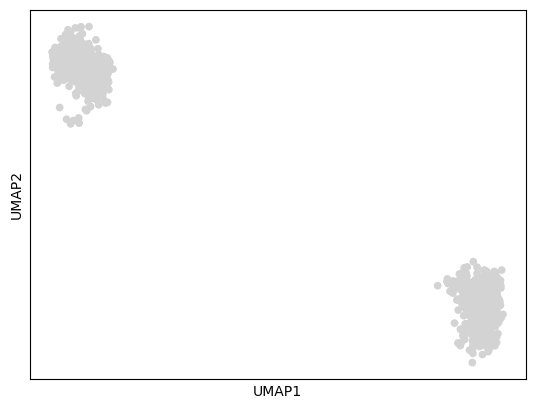

In [ ]:
sc.pl.umap(aa)

In [ ]:
aa = d.downstream_recipe(aa, min_perc=10, n_clusters=2)


Removed 0 edges (kept 7682 edges).


In [ ]:
nets = [pd.read_csv(filename, sep='\t') for filename in dataset_config.edgelist]

for net in nets:

    print(f" Intersection with GT1 I: {pd.merge(aa.var, net, on=['source', 'target'], how='inner').shape}")


 Intersection with GT1 I: (7, 9)
 Intersection with GT1 I: (19, 9)


In [ ]:
gene_inter_adata = aa.copy()
print("Gene interaintion adata")
print(gene_inter_adata)
print("\n\n Gene expression adata")
adata = adata[gene_inter_adata.obs_names,:]
adata

Gene interaintion adata
AnnData object with n_obs × n_vars = 970 × 7682
    obs: 'cell_id', 'grn', 'leiden', 'leiden_0', 'leiden_1', 'consensus', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'source', 'target', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'pca', 'neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


 Gene expression adata


View of AnnData object with n_obs × n_vars = 970 × 238
    obs: 'cell_id', 'grn', 'leiden'
    var: 'genes', 'mean', 'std'

In [ ]:
results_df, all_edges, data = d.filter_signatures_by_cluster(adata, gene_inter_adata, cluster="0", top_per_source=250, min_regulon_size=10, ncores=100)

196 source based groups are found
7480 edges are found


[1] "dimensions of the resulting scores"
[1] 970 196




In [ ]:
grn_adata_ = d.filter_grn_by_top_signatures(gene_inter_adata, results_df, all_edges, keep_top_ranked=100)
grn_adata_

top_n.shape: (100, 5)
Filtered edge count: 3857


AnnData object with n_obs × n_vars = 970 × 3857
    obs: 'leiden'
    var: 'source', 'target'

In [ ]:
print(f"grn_adata_ : {grn_adata_}")

for net in nets:

    print(f" Intersection with GT1 I: {pd.merge(grn_adata_.var, net, on=['source', 'target'], how='inner').shape}")


grn_adata_ : AnnData object with n_obs × n_vars = 970 × 3857
    obs: 'leiden'
    var: 'source', 'target'
 Intersection with GT1 I: (3, 2)
 Intersection with GT1 I: (18, 2)


In [ ]:
adata_regl = d.create_regulon_activity_adata(data, gene_inter_adata, grn_adata_)
adata_regl

AnnData object with n_obs × n_vars = 970 × 100
    obs: 'cell_id', 'grn', 'leiden', 'leiden_0', 'leiden_1', 'consensus', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    obsm: 'X_umap'

In [ ]:
net.source.unique()

array(['TFAP2A', 'TFAP2B', 'TFAP2C', 'TFAP2D', 'AEBP1', 'AEBP2'],
      dtype=object)

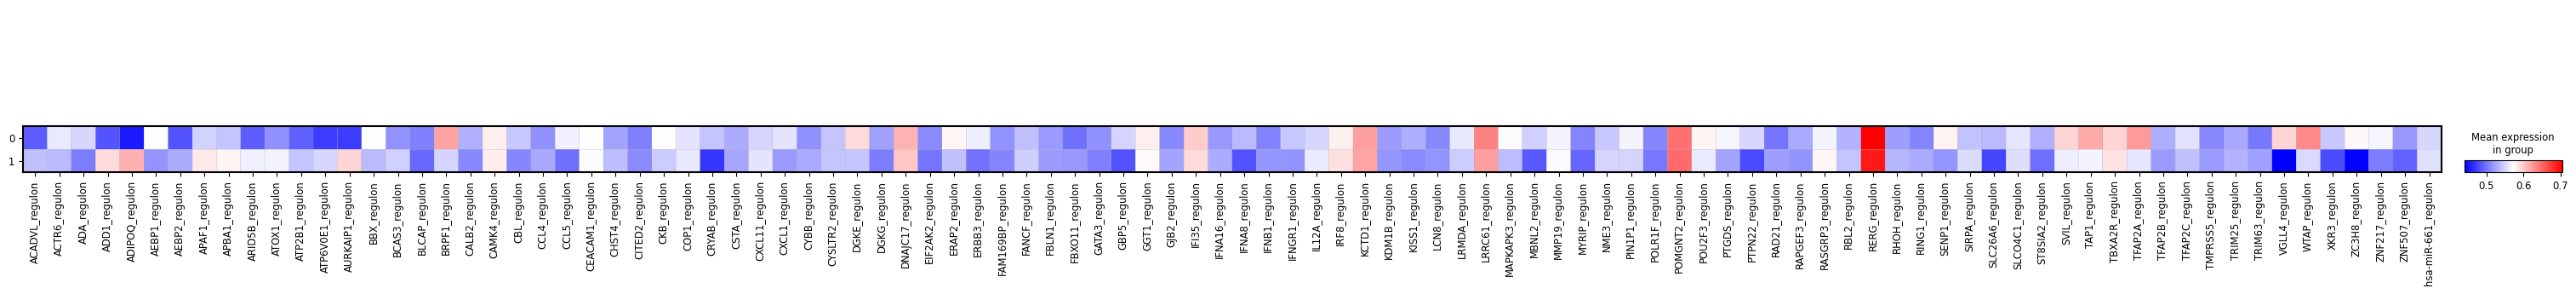

In [ ]:
marker_genes = list(adata_regl.var.index)

ax = sc.pl.matrixplot(adata_regl, marker_genes, groupby='leiden', cmap='bwr')

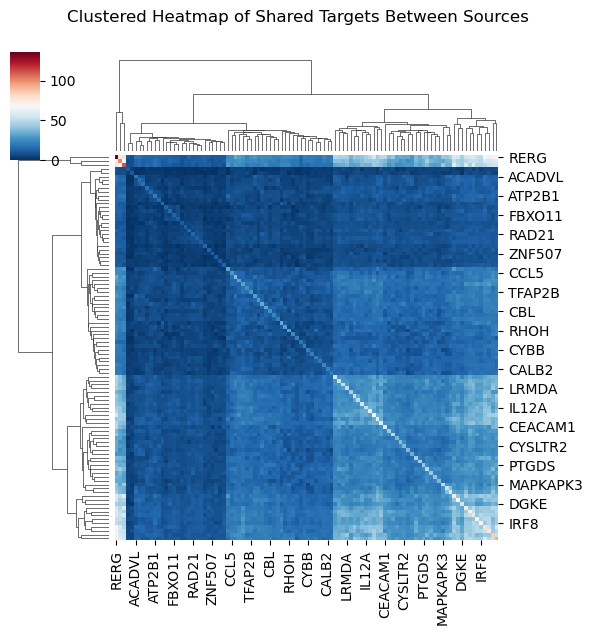

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# Load your data
df = grn_adata_.var

# Step 1: Build mapping from source to set of targets
source_targets = df.groupby('source')['target'].apply(set)

# Step 2: Create similarity matrix
sources = source_targets.index.tolist()
shared_target_matrix = pd.DataFrame(0, index=sources, columns=sources)

# Step 3: Count shared targets for each source pair
for src1, src2 in combinations(sources, 2):
    shared = len(source_targets[src1] & source_targets[src2])
    shared_target_matrix.loc[src1, src2] = shared
    shared_target_matrix.loc[src2, src1] = shared

# Fill diagonal with number of targets per source
for src in sources:
    shared_target_matrix.loc[src, src] = len(source_targets[src])

# Step 4: Clustered heatmap
sns.clustermap(shared_target_matrix, cmap='RdBu_r', figsize=(6, 6), metric='euclidean', method='average')
plt.suptitle('Clustered Heatmap of Shared Targets Between Sources', y=1.05)
plt.show()

In [ ]:
# Downstream processing defaults
DEFAULT_MIN_PERC = 10           # Minimum % of cells expressing a gene to keep it
DEFAULT_N_CLUSTERS = 2          # Number of clusters for filtering/labeling

# Edge filtering
DEFAULT_MIN_MEAN_COUNT = 0.0005  # Minimum mean edge weight (strength) to retain

# Signature filtering
DEFAULT_TOP_PER_SOURCE = 200    # Max signatures to retain per source gene
DEFAULT_MIN_REGULON_SIZE = 10   # Minimum number of targets in a regulon to retain it
DEFAULT_NCORES = 100            # Number of parallel workers to use

# GRN filtering
DEFAULT_KEEP_TOP_RANKED = 100    # Top N signatures to keep from filtered results


In [ ]:
# Apply defaults explicitly for clarity
aa = d.downstream_recipe(grn_adata, min_perc=DEFAULT_MIN_PERC, n_clusters=DEFAULT_N_CLUSTERS)

aa = d.filter_low_count_edges(aa, min_mean_count=DEFAULT_MIN_MEAN_COUNT)

gene_inter_adata = aa.copy()

# Align adata to gene interaction AnnData
adata = adata[gene_inter_adata.obs_names, :]

clusters_adata = []
for cluster_ in gene_inter_adata.obs["leiden"].unique():

    print(f"Cluster: {cluster_}")
    # Filter significant signatures
    results_df, all_edges, data = d.filter_signatures_by_cluster(
        adata,
        gene_inter_adata,
        cluster=cluster_,
        top_per_source=DEFAULT_TOP_PER_SOURCE,
        min_regulon_size=DEFAULT_MIN_REGULON_SIZE,
        ncores=DEFAULT_NCORES
    )

    # Keep only most significant interactions
    grn_adata_ = d.filter_grn_by_top_signatures(
        gene_inter_adata,
        results_df,
        all_edges,
        keep_top_ranked=DEFAULT_KEEP_TOP_RANKED
    )
    clusters_adata.append(grn_adata_)
    print(f"Cluster {cluster_} GRN size: {grn_adata_.shape}")



Removed 0 edges (kept 56644 edges).
Filtered out 0 genes (kept 56644).
Cluster: 0
238 source based groups are found
56644 edges are found


[1] "dimensions of the resulting scores"
[1] 970 238


top_n.shape: (100, 5)
Filtered edge count: 20000
Cluster 0 GRN size: (970, 20000)
Cluster: 1
238 source based groups are found
56644 edges are found


[1] "dimensions of the resulting scores"
[1] 970 238


top_n.shape: (100, 5)
Filtered edge count: 20000
Cluster 1 GRN size: (970, 20000)


In [ ]:
clusters_adata

[AnnData object with n_obs × n_vars = 970 × 20000
     obs: 'leiden'
     var: 'source', 'target',
 AnnData object with n_obs × n_vars = 970 × 20000
     obs: 'leiden'
     var: 'source', 'target']

In [ ]:
myad = sc.read_h5ad('/data_nfs/og86asub/netmap/netmap-evaluation/results/csnet/config/config_easy/net_51_43266_net_82_42088_net_105_43582/csnet.csn.h5ad')

In [ ]:

myad.X.nonzero()

(array([  2,   3,   4,   8,  40,  40,  40,  40,  40,  40,  40,  55,  56,
         73,  83,  83,  83,  87, 118, 161, 178, 182, 182, 182, 184, 201,
        203, 210, 210, 210, 210, 212, 215, 215, 215, 233, 278, 281, 283,
        285, 299, 301, 305, 315, 321, 324, 324, 324, 330, 361, 366, 366,
        366, 372, 427, 463, 472, 492, 502, 513, 514, 517, 517, 517, 541,
        560, 560, 560, 566, 577, 580, 595, 595, 595, 595, 609, 619, 643,
        644, 658, 687, 706, 719, 735, 744, 744, 744, 758, 780, 792, 792,
        792, 795, 807, 828, 831, 839, 847, 916, 918, 931, 940, 949, 957,
        990, 990, 990, 990], dtype=int32),
 array([10755, 30353, 44454, 29397,  9167, 29312, 29397, 29408, 29460,
        32015, 44391, 30353, 21749, 30353, 21749, 21842, 43883, 30353,
        30353, 29397, 44454, 21749, 21842, 43883, 29397, 44454, 10755,
        29397, 29401, 30349, 30353, 44454, 10755, 10896, 44313, 30353,
        29397, 30353, 44454, 30353, 29397, 30353, 44454, 29397, 29397,
        44454, 444

In [ ]:
myad[40,].X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 7 stored elements and shape (1, 56644)>

In [ ]:

## Load config and setup outputs
os.makedirs(config.output_directory, exist_ok=True)
sc.settings.figdir = config.output_directory
config.write_yaml(yaml_file=op.join(config.output_directory, 'config.yaml'))

## load data
adata = sc.read_h5ad(config.input_data)

In [ ]:
adata.var

,genes
ACADVL,ACADVL
ACTR6,ACTR6
ADA,ADA
ADD1,ADD1
ADIPOQ,ADIPOQ
...,...
ZFHX2,ZFHX2
ZNF217,ZNF217
ZNF503,ZNF503
ZNF507,ZNF507


In [ ]:
import itertools
edgenames = []
for i in itertools.product(adata.var['genes'], adata.var['genes']):
    edgenames.append(f"{i[0]}_{i[1]}")

In [ ]:
edgenames

['ACADVL_ACADVL',
 'ACADVL_ACTR6',
 'ACADVL_ADA',
 'ACADVL_ADD1',
 'ACADVL_ADIPOQ',
 'ACADVL_AEBP1',
 'ACADVL_AEBP2',
 'ACADVL_APAF1',
 'ACADVL_APBA1',
 'ACADVL_ARID5B',
 'ACADVL_ATOX1',
 'ACADVL_ATP2B1',
 'ACADVL_ATP6V0E1',
 'ACADVL_AURKAIP1',
 'ACADVL_BBX',
 'ACADVL_BCAS3',
 'ACADVL_BLCAP',
 'ACADVL_BLOC1S1',
 'ACADVL_BPIFB1',
 'ACADVL_BRPF1',
 'ACADVL_CALB2',
 'ACADVL_CAMK4',
 'ACADVL_CASP1',
 'ACADVL_CBL',
 'ACADVL_CCL19',
 'ACADVL_CCL27',
 'ACADVL_CCL4',
 'ACADVL_CCL5',
 'ACADVL_CD36',
 'ACADVL_CD5',
 'ACADVL_CD80',
 'ACADVL_CEACAM1',
 'ACADVL_CFB',
 'ACADVL_CHST2',
 'ACADVL_CHST4',
 'ACADVL_CITED2',
 'ACADVL_CKB',
 'ACADVL_CLIC3',
 'ACADVL_COMMD7',
 'ACADVL_COP1',
 'ACADVL_CREB5',
 'ACADVL_CRYAB',
 'ACADVL_CSTA',
 'ACADVL_CTNNA2',
 'ACADVL_CTNNAL1',
 'ACADVL_CTSS',
 'ACADVL_CXCL1',
 'ACADVL_CXCL10',
 'ACADVL_CXCL11',
 'ACADVL_CYBB',
 'ACADVL_CYSLTR2',
 'ACADVL_DCBLD2',
 'ACADVL_DGKE',
 'ACADVL_DGKG',
 'ACADVL_DNAJC17',
 'ACADVL_DUSP16',
 'ACADVL_ECE1',
 'ACADVL_ECM1',
 'ACADVL_EI